## Imports

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
%run process_single_4.py --debug --test --leave-movie --verbose --recording="/data/Sandra/2019/2019_07_01/Experiment22.lif" --series="Series025" --spatial-filter="6"

           recording /data/Sandra/2019/2019_07_01/Experiment22.lif
              series Series025
            restrict 
             use_tif None
         leave_movie True
             verbose True
       leave_pickles False
                test True
          only_movie False
      spatial_filter 6
           line_scan none
               debug True
importing modules...
importing series...
/data/Sandra/2019/2019_07_01/Experiment22.lif_analysis/Series025 exists already.
Resizing the movie resolution by 2...
Movie already exists, and I leave it be.
		 ##### (6,)
processing with filter size of  (6,)
initiallized with 1058 rois.
215 subsumed into existing ROIs.
81 subsumed into existing ROIs.
39 subsumed into existing ROIs.
4 subsumed into existing ROIs.


In [6]:
regions.detrend_traces()

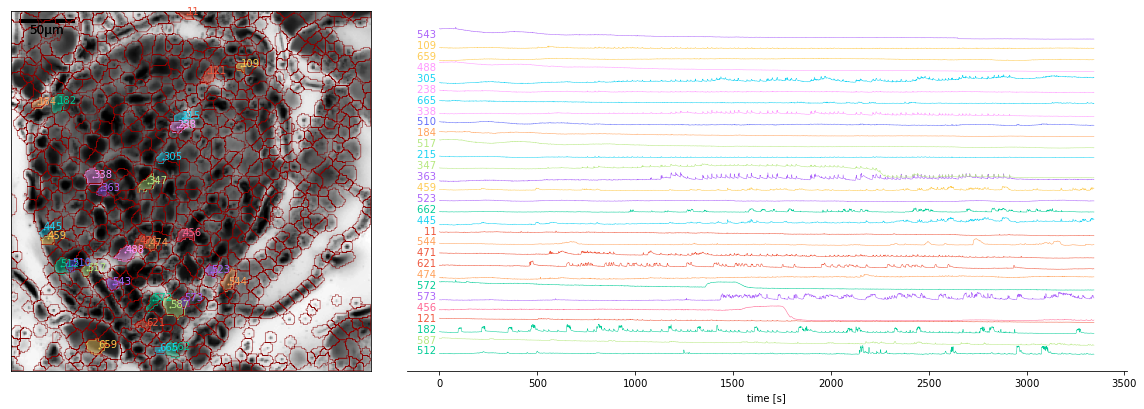

In [7]:
regions.plotTraces(regions.df.sort_values("interest", ascending=False).index[:30])

In [8]:
from islets.Regions1 import load_regions

In [9]:
old_regions = load_regions("/data/Sandra/2019/2019_07_01/Experiment22.lif_analysis/Series025/6_rois.pkl")

/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:796: RuntimeWarning: invalid value encountered in true_divide
  zScore = absFast/std
/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:610: RuntimeWarning: divide by zero encountered in log
  d = np.digitize(np.log(slow_est), logbs)


In [10]:
old_regions.calc_interest()

In [1]:
old_regions.df["color"] = ["blue"]*len(old_regions.df)

NameError: name 'old_regions' is not defined

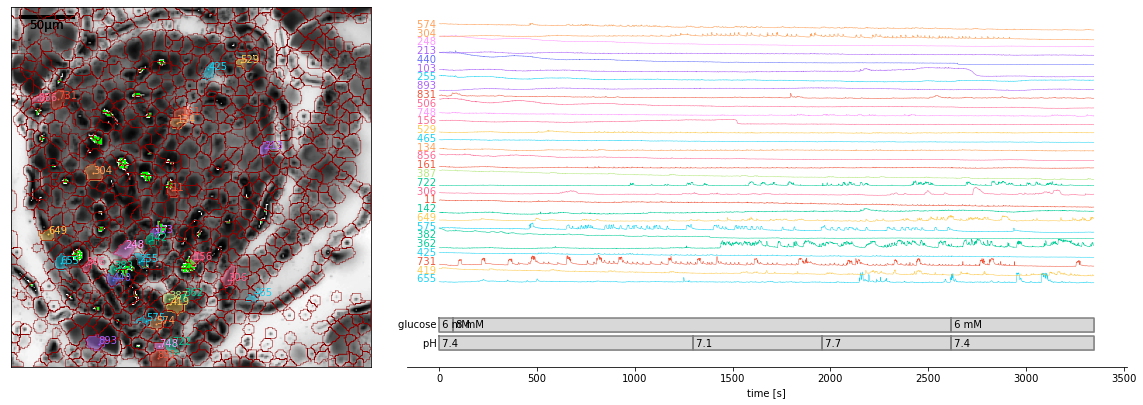

In [11]:
old_regions.plotTraces(old_regions.df.sort_values("interest", ascending=False).index[:30])

In [ ]:
old_regions.plot

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# ## importing stuff
# import os
# import pickle
# from sys import path as syspath
# syspath.append(os.path.expanduser("~/srdjan_functs/"))
# import numpy as np
# np.corrcoef(*np.random.randn(2,3))
# import matplotlib.pyplot as plt
# import warnings
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     from caiman import movie as cmovie
#     from caiman import load  as cload

# %config InlineBackend.figure_format = 'retina'
# %load_ext autoreload
# %autoreload 2

# import PicklePicker as pp
# from IPython.display import display
# import pandas as pd
# from islets.Recording import Recording, saveMovie
# from islets.Regions1 import Regions
# from islets.numeric import power_spectrum, rebin
# from islets.utils import show_movie, saveRois
# from matplotlib.colors import LogNorm
# from islets.Recording import import_data
# from islets.Regions1 import load_regions
# from islets.utils import rgb_to_hex

# import bioformats as bf


In [2]:
# %run process_single_4.py -rec="/data/Nastja/2020_11_18/Experiment3a.nd2" -ser="Series025" --verbose --debug --restrict="10_500" --spatial-filter="5" --leave-movie

In [3]:
# %run process_single_4.py -rec="/data/Nastja/2020_11_18/Experiment3a.nd2" --only-movie

In [ ]:
%run process_single_4.py -rec="/data/Nastja/2020_11_18/Experiment3a.nd2" --leave-movie --verbose

importing modules...
importing series...
/data/Nastja/2020_11_18/Experiment3a.nd2_analysis/Experiment3a exists already.
Movie already exists, and I leave it be.
		 ##### (5,)
processing with filter size of  (5,)
initiallized with 582 rois.
60 subsumed into existing ROIs.
30 subsumed into existing ROIs.


In [7]:
import_data("/data/Nastja/")

Recording /data/Nastja/2020_11_10/Experiment014f003.nd2 not yet preprocessed. Preprocessing takes a few seconds and will speed up the usage later... Recording /data/Nastja/2020_11_18/Experiment3b.nd2 not yet preprocessed. Preprocessing takes a few seconds and will speed up the usage later... Recording /data/Nastja/2020_11_18/Experiment3c.nd2 not yet preprocessed. Preprocessing takes a few seconds and will speed up the usage later... 


/home/jupyter-srdjan/srdjan_functs/islets/Recording.py:135: UserWarning: Could not parse metadata. (<class 'AttributeError'>, AttributeError("'NoneType' object has no attribute 'find_class'"), <traceback object at 0x7f734a81d6e0>)
  warn(f"Could not parse metadata. {exc_info()}")
/home/jupyter-srdjan/srdjan_functs/islets/Recording.py:135: UserWarning: Could not parse metadata. (<class 'AttributeError'>, AttributeError("'NoneType' object has no attribute 'find_class'"), <traceback object at 0x7f734a8235f0>)
  warn(f"Could not parse metadata. {exc_info()}")
/home/jupyter-srdjan/srdjan_functs/islets/Recording.py:135: UserWarning: Could not parse metadata. (<class 'AttributeError'>, AttributeError("'NoneType' object has no attribute 'find_class'"), <traceback object at 0x7f734a81d460>)
  warn(f"Could not parse metadata. {exc_info()}")


,path to exp,experiment,series,SizeT,SizeX,SizeY,SizeZ,pxSize,pxUnit,Frequency,...,path to add_info,add_info done,comments,sex,strain,species,dye,slice number,part of pancreas,microscope
0,/data/Nastja/2020_10_23/Experiment1a.nd2,Experiment1a.nd2,Experiment1a,44986,256,256,1,1.240,µm,58.6,...,/data/Nastja/2020_10_23/Experiment1a.nd2_analy...,True,nan,nan,nan,nan,nan,nan,nan,nan
1,/data/Nastja/2020_10_23/Experiment1b.nd2,Experiment1b.nd2,Experiment1b,44406,256,256,1,0.829,µm,59.0,...,/data/Nastja/2020_10_23/Experiment1b.nd2_analy...,True,nan,Male,C57BL/6J,Mouse,Calbryte 520,nan,nan,Nikon
2,/data/Nastja/2020_10_30/Experiment2a.nd2,Experiment2a.nd2,Experiment2a,34492,512,512,1,0.621,µm,30.1,...,/data/Nastja/2020_10_30/Experiment2a.nd2_analy...,True,nan,nan,nan,nan,nan,nan,nan,nan
3,/data/Nastja/2020_10_30/Experiment2b.nd2,Experiment2b.nd2,Experiment2b,20007,512,512,1,0.621,µm,30.1,...,/data/Nastja/2020_10_30/Experiment2b.nd2_analy...,True,nan,nan,nan,nan,nan,nan,nan,nan
4,/data/Nastja/2020_10_30/Experiment2c.nd2,Experiment2c.nd2,Experiment2c,53567,256,256,1,1.240,µm,58.6,...,/data/Nastja/2020_10_30/Experiment2c.nd2_analy...,True,nan,nan,nan,nan,nan,nan,nan,nan
5,/data/Nastja/2020_11_18/Experiment3a.nd2,Experiment3a.nd2,Experiment3a,62385,256,256,1,1.240,µm,58.6,...,/data/Nastja/2020_11_18/Experiment3a.nd2_analy...,True,nan,nan,nan,nan,nan,nan,nan,nan


In [16]:
regions = load_regions(regions.pathToPickle, mergeDist=0)

In [4]:
# regions.plotTraces(regions.df.index, col="trace")

In [7]:
del regions.metadata

300 subsumed into existing ROIs.
106 subsumed into existing ROIs.


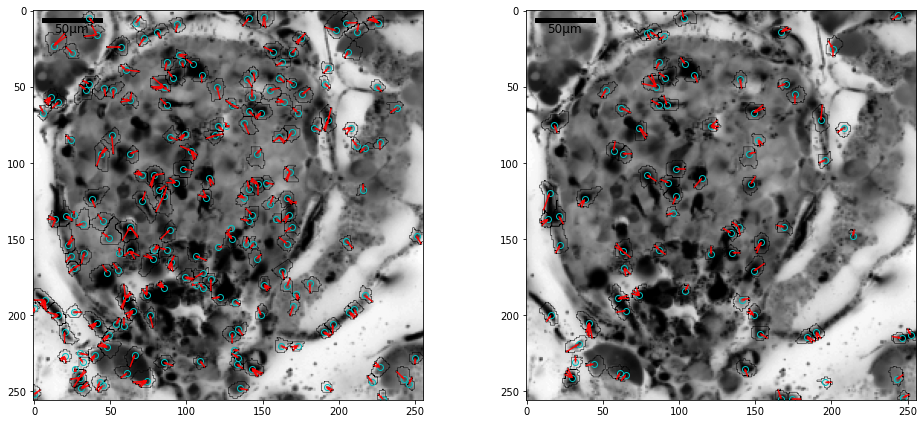

In [17]:
regions.merge_closest(plot=True, Niter=2, verbose=True)

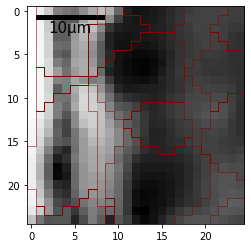

In [3]:
regions.plotEdges()

In [2]:
# saveMovie(movie,"embed")

In [4]:
from IPython.display import Video
Video(movieFilename, embed=True)

In [9]:
HTML(f"""
    <video alt="test" width="320" height="240" controls>
        <source src="{movieFilename}" type="video/mp4">
    </video>
""")


In [2]:
rec = Recording()

In [3]:
serToImport = "Series025"

In [4]:
restrict = (10,-3000)

In [5]:
bf.javabridge.start_vm(class_path=bf.JARS)
rec.import_series(serToImport, restrict=restrict)
bf.javabridge.kill_vm()

In [13]:
movie = cmovie(
    rec.Series[serToImport]["data"],
    fr = rec.Series[serToImport]["metadata"]["Frequency"],
              )

In [14]:
metadata = rec.Series[serToImport]["metadata"]

In [15]:
# show_movie(movie[:,::2,::2].astype("float32")+1, autoadjust=False, log=True)

In [16]:
movie = movie.resize(.5,.5,1)

In [17]:
show_movie(movie[:3])

In [12]:
metadata.pxSizeze

AttributeError: 'Series' object has no attribute 'pxSizeze'

In [18]:
#     if len(pathToCorrected):
#         movie = cload(
#             pathToCorrected,
#             fr=metadata.Frequency,
#             outtype=metadata['bit depth']
#         )
#         FrameRange = metadata.frame_range
#         movie = movie[FrameRange[0]:FrameRange[1]]
#     else:
#         movie = cmovie(
#             rec.Series[serToImport]['data'],
#             fr=metadata.Frequency
#         )

In [27]:
# ser = serToImport

In [28]:
saveDir = os.path.join(rec.folder, rec.Experiment+"_analysis", ser)

In [29]:
if len(rec.metadata)==1:
    movieFilename = os.path.join(saveDir, os.path.splitext(rec.Experiment)[0]+".mp4")
else:
    movieFilename = os.path.join(saveDir, rec.Experiment+"_"+ser+".mp4")

In [42]:
movie.fr = None

In [31]:
# metadata.pxSize

In [ ]:
def process_movie(movie, metadata, test=False, debug=False, verbose=0):
    


    if metadata.pxSize<.8:
        if args.verbose: print ("Resizing the movie resolution by 2...")
        movie = movie.resize(1/2,1/2,1)
        metadata.pxSize *= 2
        metadata.SizeX /= 2
        metadata.SizeY /= 2

    writeMovie = True
    if os.path.isfile(movieFilename):
        if args.verbose: print("Movie already exists, ", end="")
        if args.leave_movie:
            writeMovie = False
            if args.verbose: print("and I leave it be.")
        else:
            if args.verbose: print("and I'll rewrite it.")
    if writeMovie:
        if args.verbose: print("Writing the movie...")
        if not args.test: saveMovie(movie,movieFilename)

    if not args.only_movie: 


        #### protocol filename
        protocolFilename = movieFilename.replace(".mp4", "_protocol.txt")
        if not os.path.isfile(protocolFilename):
            if args.verbose: print("placed dummy protocol file at", protocolFilename)
            if not args.test:
                DataFrame([[None]*4],columns=["compound","concentration","begin","end"]).to_csv(protocolFilename,index=False)

        filtSizes = get_filterSizes(metadata.pxSize)

        # anull saturated above threshold
#         Nsatur = (movie==movie.max()).sum(0)
#         toAnull = np.where(Nsatur>len(movie)*fracSaturTh)
#         movie[(slice(None), )+toAnull] = 0


        for spFilt in filtSizes:
            if args.verbose: print ("\t"*2,"#"*5,spFilt)

            pickleFile = os.path.join(saveDir, ".".join(map(str,spFilt))+"_rois.pkl")
            if os.path.isfile(pickleFile) and args.leave_pickles:
                if args.verbose: print ("already exists, skipping.")
                continue
            else:
                if args.verbose: print ("processing with filter size of ", spFilt)

            regions = Regions(movie,gSig_filt=spFilt,diag=True)
            regions.time += t0
            if args.verbose:
                print (f"initiallized with {len(regions.df)} rois.")

            regions.purge_lones((min(spFilt)*.4)**2, verbose=args.verbose)
            regions.sortFromCenter()
            regions.calcTraces()
            regions.metadata = metadata
            if not args.test: 
                saveRois(regions, saveDir, filename= ".".join(map(str,spFilt)), add_date=False, formats=["vienna"])

            # preview image
            del regions